# Baseline model based on anatomy features

In [1]:
path = ".."

import sys
sys.path.insert(0, path)

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn

In [3]:
from problem import get_train_data, get_test_data

data_train, labels_train = get_train_data(path=path)
data_test, labels_test = get_test_data(path=path)

data_train['participants_sex'] = data_train['participants_sex'].map({'F': 0, 'M': 1}) 

In [4]:
data_train.shape, data_test.shape

((1127, 220), (23, 220))

In [33]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, StratifiedShuffleSplit


def evaluation(X, y):
    pipe = make_pipeline(FeatureExtractor(), Classifier())
    cv = StratifiedShuffleSplit(n_splits=10, test_size=0.5, random_state=42).split(X, y)
    results = cross_validate(pipe, X, y, scoring=['roc_auc', 'accuracy'], cv=cv,
                             verbose=1, return_train_score=True,
                             n_jobs=1)
    
    return results

### Basic logistic regression 

In [21]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline


anatomy_cols = [col for col in data_train.columns if col.startswith('anatomy')]
anatomy_cols.remove('anatomy_select')
participant_cols = [col for col in data_train.columns if col.startswith('participant')]
participant_cols.remove('participants_site')


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        X = X_df[anatomy_cols + participant_cols]
        return X
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), LogisticRegression())

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [22]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.908 +- 0.009
Validation score ROC-AUC: 0.638 +- 0.014 

Training score accuracy: 0.826 +- 0.015
Validation score accuracy: 0.602 +- 0.017


[Parallel(n_jobs=8)]: Done   6 out of  10 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  10 out of  10 | elapsed:    0.6s finished


```
Training score ROC-AUC: 0.851 +- 0.004
Validation score ROC-AUC: 0.654 +- 0.018 

Training score accuracy: 0.771 +- 0.006
Validation score accuracy: 0.627 +- 0.018
```

Let's visualize feature importance:

In [23]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [24]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [25]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['logisticregression']

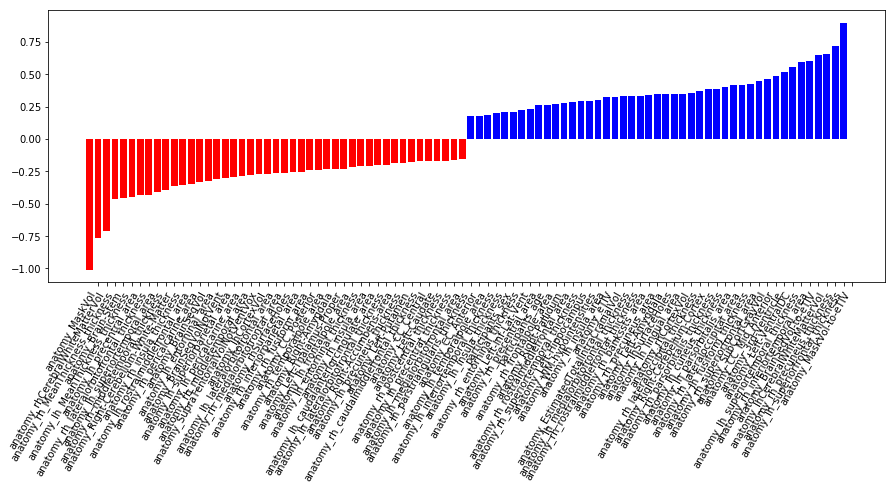

In [26]:
cols = anatomy_cols + participant_cols

visualize_coefficients(log_reg, feature_names=cols, n_top_features=45)

In [73]:
n_top_features = 42
coef = log_reg.coef_.ravel()
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

In [74]:
topk_feature_names = np.array(cols)[interesting_coefficients].tolist()

In [75]:
print("[", end="")
for f in topk_feature_names:
    print("\"{}\"".format(f), end=", ")
print("]")

["anatomy_MaskVol", "anatomy_rhCerebralWhiteMatterVol", "anatomy_rh_MeanThickness_thickness", "anatomy_Brain-Stem", "anatomy_lh_MeanThickness_thickness", "anatomy_lh_precentral_area", "anatomy_rh_lateralorbitofrontal_thickness", "anatomy_lh_superiortemporal_area", "anatomy_rh_middletemporal_thickness", "anatomy_Right-Cerebellum-White-Matter", "anatomy_rh_insula_thickness", "anatomy_lh_rostralmiddlefrontal_area", "anatomy_rh_pericalcarine_area", "anatomy_BrainSegVol", "anatomy_lh_entorhinal_area", "anatomy_BrainSegVolNotVent", "anatomy_lh_superiorparietal_area", "anatomy_lh_pericalcarine_area", "anatomy_rh_middletemporal_area", "anatomy_SupraTentorialVolNotVentVox", "anatomy_lhCortexVol", "anatomy_lh_lateralorbitofrontal_area", "anatomy_rh_medialorbitofrontal_area", "anatomy_rhSurfaceHoles", "anatomy_rh_inferiorparietal_area", "anatomy_rh_fusiform_area", "anatomy_CC_Posterior", "anatomy_rh_temporalpole_area", "anatomy_Right-Amygdala", "anatomy_Left-Thalamus-Proper", "anatomy_lh_frontalp

### Basic logistic regression with filtered features 

In [71]:
# topk_feature_names = ["anatomy_MaskVol", "anatomy_rhCerebralWhiteMatterVol", "anatomy_rh_MeanThickness_thickness", "anatomy_Brain-Stem", "anatomy_lh_MeanThickness_thickness", "anatomy_lh_precentral_area", "anatomy_rh_lateralorbitofrontal_thickness", "anatomy_lh_superiortemporal_area", "anatomy_rh_middletemporal_thickness", "anatomy_Right-Cerebellum-White-Matter", "anatomy_rh_insula_thickness", "anatomy_lh_rostralmiddlefrontal_area", "anatomy_rh_pericalcarine_area", "anatomy_BrainSegVol", "anatomy_lh_entorhinal_area", "anatomy_BrainSegVolNotVent", "anatomy_lh_superiorparietal_area", "anatomy_lh_pericalcarine_area", "anatomy_rh_middletemporal_area", "anatomy_SupraTentorialVolNotVentVox", "anatomy_lhCortexVol", "anatomy_lh_lateralorbitofrontal_area", "anatomy_rh_medialorbitofrontal_area", "anatomy_rhSurfaceHoles", "anatomy_rh_inferiorparietal_area", "anatomy_rh_fusiform_area", "anatomy_CC_Posterior", "anatomy_rh_temporalpole_area", "anatomy_Right-Amygdala", "anatomy_Left-Thalamus-Proper", "anatomy_lh_frontalpole_area", "anatomy_lh_entorhinal_thickness", "anatomy_rh_insula_area", "anatomy_lh_caudalanteriorcingulate_area", "anatomy_lh_lateralorbitofrontal_thickness", "anatomy_Right-Accumbens-area", "anatomy_lh_precuneus_thickness", "anatomy_Left-Putamen", "anatomy_rh_caudalmiddlefrontal_thickness", "anatomy_CC_Central", "anatomy_Left-Caudate", "participants_sex", "anatomy_rh_entorhinal_thickness", "anatomy_Left-Inf-Lat-Vent", "anatomy_rh_precentral_area", "participants_age", "anatomy_rh_frontalpole_area", "anatomy_Right-Pallidum", "anatomy_rh_rostralmiddlefrontal_area", "anatomy_rh_superiortemporal_thickness", "anatomy_Left-Hippocampus", "anatomy_WM-hypointensities", "anatomy_lh_insula_area", "anatomy_eTIV", "anatomy_EstimatedTotalIntraCranialVol", "anatomy_lh_medialorbitofrontal_thickness", "anatomy_rh_rostralmiddlefrontal_thickness", "anatomy_rh_bankssts_area", "anatomy_rh_precuneus_area", "anatomy_Left-Amygdala", "anatomy_lhSurfaceHoles", "anatomy_lh_lingual_area", "anatomy_rhCortexVol", "anatomy_rh_lateraloccipital_thickness", "anatomy_Right-Cerebellum-Cortex", "anatomy_rh_parsorbitalis_thickness", "anatomy_lh_cuneus_thickness", "anatomy_lh_parsorbitalis_area", "anatomy_rh_lateraloccipital_area", "anatomy_lh_fusiform_thickness", "anatomy_rh_superiorfrontal_area", "anatomy_SubCortGrayVol", "anatomy_CC_Mid_Anterior", "anatomy_3rd-Ventricle", "anatomy_Left-VentralDC", "anatomy_lh_superiortemporal_thickness", "anatomy_rh_inferiortemporal_area", "anatomy_BrainSegVol-to-eTIV", "anatomy_lhCerebralWhiteMatterVol", "anatomy_rh_precuneus_thickness", "anatomy_lh_superiorfrontal_thickness", "anatomy_MaskVol-to-eTIV"]


class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[topk_feature_names]
        return X
    
    
from sklearn.linear_model import LogisticRegressionCV
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        
        pipe_cv = make_pipeline(StandardScaler(), 
                                LogisticRegressionCV(Cs=np.logspace(-2, 6, num=10), 
                                                     n_jobs=8, scoring="roc_auc"))
        pipe_cv.fit(X, y)
        best_C = pipe_cv.named_steps['logisticregressioncv'].C_[0]
        self.clf = make_pipeline(StandardScaler(), LogisticRegression(C=best_C))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)


In [72]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.839 +- 0.010
Validation score ROC-AUC: 0.723 +- 0.009 

Training score accuracy: 0.761 +- 0.015
Validation score accuracy: 0.665 +- 0.014


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    9.6s finished


Test size 0.5

45 
```
Training score ROC-AUC: 0.849 +- 0.012
Validation score ROC-AUC: 0.718 +- 0.009 

Training score accuracy: 0.765 +- 0.013
Validation score accuracy: 0.660 +- 0.015
```

43
```
Training score ROC-AUC: 0.843 +- 0.010
Validation score ROC-AUC: 0.723 +- 0.011 

Training score accuracy: 0.761 +- 0.012
Validation score accuracy: 0.663 +- 0.012

```

42
```
Training score ROC-AUC: 0.840 +- 0.010
Validation score ROC-AUC: 0.723 +- 0.010 

Training score accuracy: 0.762 +- 0.016
Validation score accuracy: 0.665 +- 0.008
```

41
```
Training score ROC-AUC: 0.839 +- 0.010
Validation score ROC-AUC: 0.723 +- 0.009 

Training score accuracy: 0.761 +- 0.015
Validation score accuracy: 0.665 +- 0.014
```

40 
```
Training score ROC-AUC: 0.837 +- 0.010
Validation score ROC-AUC: 0.721 +- 0.011 

Training score accuracy: 0.760 +- 0.014
Validation score accuracy: 0.663 +- 0.015
```

38
```
Training score ROC-AUC: 0.829 +- 0.009
Validation score ROC-AUC: 0.717 +- 0.009 

Training score accuracy: 0.748 +- 0.011
Validation score accuracy: 0.657 +- 0.012
```

Baseline: test size 0.2
```
Training score ROC-AUC: 0.825 +- 0.005
Validation score ROC-AUC: 0.743 +- 0.022 

Training score accuracy: 0.750 +- 0.009
Validation score accuracy: 0.689 +- 0.012
```

### Basic ElasticNet regression 

In [45]:
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.pipeline import make_pipeline


seed = 17

class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[[col for col in X_df.columns if col.startswith('anatomy')]]
        return X.drop(columns='anatomy_select')
        

class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = make_pipeline(StandardScaler(), ElasticNet(alpha=0.015, l1_ratio=0.3, random_state=seed))

    def fit(self, X, y):
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(np.int)

    def predict_proba(self, X):
        probas = self.clf.predict(X)
        probas = probas.reshape((-1, 1))
        return np.concatenate([probas, probas], axis=1)        


In [46]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.822 +- 0.004
Validation score ROC-AUC: 0.662 +- 0.017 

Training score accuracy: 0.741 +- 0.009
Validation score accuracy: 0.626 +- 0.030


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    1.1s finished


Let's visualize feature importance:

In [48]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

In [49]:
pipe = make_pipeline(FeatureExtractor(), Classifier())
pipe.fit(data_train, labels_train)

Pipeline(memory=None,
     steps=[('featureextractor', FeatureExtractor()), ('classifier', Classifier())])

In [52]:
log_reg = pipe.named_steps['classifier'].clf.named_steps['elasticnet']

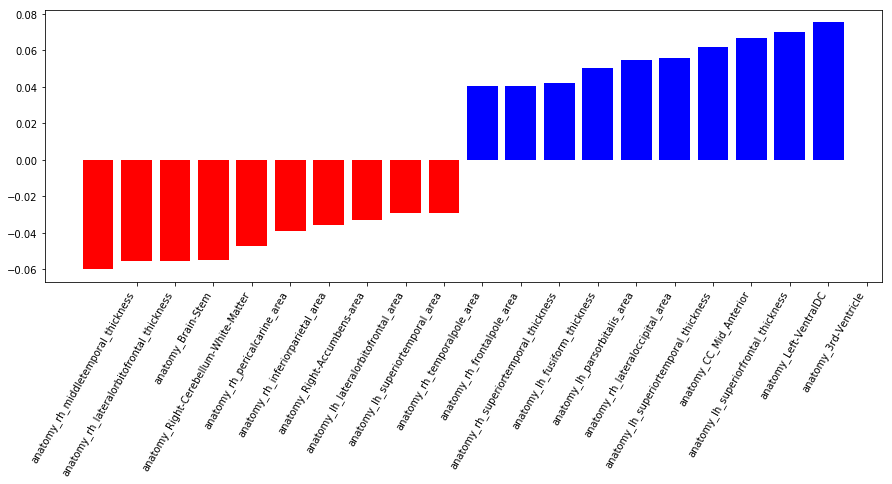

In [53]:
cols=[col for col in data_train.columns if col.startswith('anatomy')]

visualize_coefficients(log_reg, feature_names=cols, n_top_features=10)

In [121]:
n_top_features = 25
coef = log_reg.coef_.ravel()
positive_coefficients = np.argsort(coef)[-n_top_features:]
negative_coefficients = np.argsort(coef)[:n_top_features]
interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])

In [122]:
topk_feature_names = np.array(cols)[interesting_coefficients].tolist()

### Basic ElasticNet with filtered features 

In [126]:
elasticnet_features = ['anatomy_rh_middletemporal_thickness',
 'anatomy_rh_lateralorbitofrontal_thickness',
 'anatomy_Brain-Stem',
 'anatomy_Right-Cerebellum-White-Matter',
 'anatomy_rh_pericalcarine_area',
 'anatomy_rh_inferiorparietal_area',
 'anatomy_Right-Accumbens-area',
 'anatomy_lh_lateralorbitofrontal_area',
 'anatomy_lh_superiortemporal_area',
 'anatomy_rh_temporalpole_area',
 'anatomy_lh_parahippocampal_thickness',
 'anatomy_rh_postcentral_thickness',
 'anatomy_lh_precentral_thickness',
 'anatomy_lh_entorhinal_area',
 'anatomy_rh_precentral_thickness',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_rh_medialorbitofrontal_area',
 'anatomy_lh_frontalpole_area',
 'anatomy_lh_caudalanteriorcingulate_area',
 'anatomy_lh_precentral_area',
 'anatomy_lh_inferiorparietal_thickness',
 'anatomy_lh_medialorbitofrontal_area',
 'anatomy_Left-Thalamus-Proper',
 'anatomy_CC_Central',
 'anatomy_rh_caudalanteriorcingulate_thickness',
 'anatomy_lh_temporalpole_area',
 'anatomy_Right-Cerebellum-Cortex',
 'anatomy_lh_lingual_area',
 'anatomy_lh_medialorbitofrontal_thickness',
 'anatomy_Left-Inf-Lat-Vent',
 'anatomy_rh_bankssts_area',
 'anatomy_rh_precuneus_area',
 'anatomy_rh_inferiortemporal_area',
 'anatomy_Left-Amygdala',
 'anatomy_rh_precuneus_thickness',
 'anatomy_rh_lateraloccipital_thickness',
 'anatomy_rh_superiorfrontal_area',
 'anatomy_WM-hypointensities',
 'anatomy_rh_parsorbitalis_thickness',
 'anatomy_lh_cuneus_thickness',
 'anatomy_rh_frontalpole_area',
 'anatomy_rh_superiortemporal_thickness',
 'anatomy_lh_fusiform_thickness',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_rh_lateraloccipital_area',
 'anatomy_lh_superiortemporal_thickness',
 'anatomy_CC_Mid_Anterior',
 'anatomy_lh_superiorfrontal_thickness',
 'anatomy_Left-VentralDC',
 'anatomy_3rd-Ventricle']



class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        X = X_df[elasticnet_features]
        return X
    
    
from sklearn.linear_model import ElasticNetCV, ElasticNet
        

seed = 15    

    
class Classifier(BaseEstimator):
    def __init__(self):
        self.clf = None

    def fit(self, X, y):
        l1_ratio = 0.4
        pipe_cv = make_pipeline(StandardScaler(), 
                        ElasticNetCV(l1_ratio=l1_ratio, n_jobs=8, random_state=seed, max_iter=10000))
        pipe_cv.fit(X, y)
        best_alpha = pipe_cv.named_steps['elasticnetcv'].alpha_        
        self.clf = make_pipeline(StandardScaler(), 
                                 ElasticNet(l1_ratio=l1_ratio, alpha=best_alpha, 
                                            random_state=seed, max_iter=10000))
        self.clf.fit(X, y)
        return self
        
    def predict(self, X):
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(np.int)
    
    def predict_proba(self, X):
        probas = self.clf.predict(X)
        probas = probas.reshape((-1, 1))
        return np.concatenate([probas, probas], axis=1)        



In [127]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.785 +- 0.004
Validation score ROC-AUC: 0.735 +- 0.016 

Training score accuracy: 0.708 +- 0.007
Validation score accuracy: 0.665 +- 0.011


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.3s finished


In [108]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.789 +- 0.004
Validation score ROC-AUC: 0.732 +- 0.017 

Training score accuracy: 0.711 +- 0.006
Validation score accuracy: 0.672 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.5s finished


Mix of LogReg+ElasticNet

In [156]:
logreg_features = [
    'anatomy_MaskVol', 'anatomy_rhCerebralWhiteMatterVol', 'anatomy_rh_MeanThickness_thickness', 'anatomy_Brain-Stem',
    'anatomy_rh_middletemporal_thickness', 'anatomy_rh_lateralorbitofrontal_thickness', 'anatomy_lh_superiortemporal_area',
    'anatomy_Right-Cerebellum-White-Matter', 'anatomy_lh_MeanThickness_thickness', 'anatomy_lh_precentral_area',
    'anatomy_rh_insula_thickness', 'anatomy_lh_rostralmiddlefrontal_area', 'anatomy_rh_pericalcarine_area',
    'anatomy_lh_pericalcarine_area',
    'anatomy_lh_lateralorbitofrontal_area',
    'anatomy_BrainSegVol',
    'anatomy_lh_entorhinal_area',
    'anatomy_lh_superiorparietal_area',
    'anatomy_rh_middletemporal_area',
    'anatomy_BrainSegVolNotVent',
    'anatomy_rhSurfaceHoles',
    'anatomy_lhCortexVol',
    'anatomy_SupraTentorialVolNotVentVox',
    'anatomy_rh_medialorbitofrontal_area',
    'anatomy_Left-Thalamus-Proper',
    'anatomy_CC_Posterior',
    'anatomy_rh_inferiorparietal_area',
    'anatomy_rh_temporalpole_area',
    'anatomy_lh_frontalpole_area',
    'anatomy_lh_caudalanteriorcingulate_area',
    'anatomy_rh_fusiform_area',
    'anatomy_Right-Accumbens-area',
    'anatomy_CC_Central',
    'anatomy_rh_caudalmiddlefrontal_thickness',
    'anatomy_Right-Amygdala',
    'anatomy_lh_entorhinal_thickness',
    'anatomy_lh_lateralorbitofrontal_thickness',
    'anatomy_lh_precentral_thickness',
    'anatomy_rh_postcentral_thickness',
    'anatomy_Left-Caudate',
    'anatomy_rh_insula_area',
    'anatomy_lh_inferiortemporal_thickness',
    'anatomy_lh_insula_thickness',
    'anatomy_rh_entorhinal_thickness',
    'anatomy_Left-Inf-Lat-Vent',
    'anatomy_rh_precentral_area',
    'anatomy_rh_frontalpole_area',
    'anatomy_WM-hypointensities',
    'anatomy_rh_rostralmiddlefrontal_area',
    'anatomy_rh_superiortemporal_thickness',
    'anatomy_Left-Hippocampus',
    'anatomy_Right-Pallidum',
    'anatomy_lh_insula_area',
    'anatomy_rhCortexVol',
    'anatomy_rh_precuneus_area',
    'anatomy_rh_bankssts_area',
    'anatomy_lh_medialorbitofrontal_thickness',
    'anatomy_eTIV',
    'anatomy_EstimatedTotalIntraCranialVol',
    'anatomy_rh_rostralmiddlefrontal_thickness',
    'anatomy_Left-Amygdala',
    'anatomy_rh_lateraloccipital_thickness',
    'anatomy_lh_lingual_area',
    'anatomy_rh_parsorbitalis_thickness',
    'anatomy_lhSurfaceHoles',
    'anatomy_lh_cuneus_thickness',
    'anatomy_SubCortGrayVol',
    'anatomy_Right-Cerebellum-Cortex',
    'anatomy_rh_superiorfrontal_area',
    'anatomy_lh_fusiform_thickness',
    'anatomy_lh_parsorbitalis_area',
    'anatomy_rh_lateraloccipital_area',
    'anatomy_CC_Mid_Anterior',
    'anatomy_Left-VentralDC',
    'anatomy_3rd-Ventricle',
    'anatomy_lh_superiortemporal_thickness',
    'anatomy_rh_inferiortemporal_area',
    'anatomy_BrainSegVol-to-eTIV',
    'anatomy_lh_superiorfrontal_thickness',
    'anatomy_rh_precuneus_thickness',
    'anatomy_lhCerebralWhiteMatterVol',
    'anatomy_MaskVol-to-eTIV']


elasticnet_features = ['anatomy_rh_middletemporal_thickness',
 'anatomy_rh_lateralorbitofrontal_thickness',
 'anatomy_Brain-Stem',
 'anatomy_Right-Cerebellum-White-Matter',
 'anatomy_rh_pericalcarine_area',
 'anatomy_rh_inferiorparietal_area',
 'anatomy_Right-Accumbens-area',
 'anatomy_lh_lateralorbitofrontal_area',
 'anatomy_lh_superiortemporal_area',
 'anatomy_rh_temporalpole_area',
 'anatomy_lh_parahippocampal_thickness',
 'anatomy_rh_postcentral_thickness',
 'anatomy_lh_precentral_thickness',
 'anatomy_lh_entorhinal_area',
 'anatomy_rh_precentral_thickness',
 'anatomy_lh_rostralmiddlefrontal_area',
 'anatomy_rh_medialorbitofrontal_area',
 'anatomy_lh_frontalpole_area',
 'anatomy_lh_caudalanteriorcingulate_area',
 'anatomy_lh_precentral_area',
 'anatomy_lh_inferiorparietal_thickness',
 'anatomy_lh_medialorbitofrontal_area',
 'anatomy_Left-Thalamus-Proper',
 'anatomy_CC_Central',
 'anatomy_rh_caudalanteriorcingulate_thickness',
 'anatomy_lh_temporalpole_area',
 'anatomy_Right-Cerebellum-Cortex',
 'anatomy_lh_lingual_area',
 'anatomy_lh_medialorbitofrontal_thickness',
 'anatomy_Left-Inf-Lat-Vent',
 'anatomy_rh_bankssts_area',
 'anatomy_rh_precuneus_area',
 'anatomy_rh_inferiortemporal_area',
 'anatomy_Left-Amygdala',
 'anatomy_rh_precuneus_thickness',
 'anatomy_rh_lateraloccipital_thickness',
 'anatomy_rh_superiorfrontal_area',
 'anatomy_WM-hypointensities',
 'anatomy_rh_parsorbitalis_thickness',
 'anatomy_lh_cuneus_thickness',
 'anatomy_rh_frontalpole_area',
 'anatomy_rh_superiortemporal_thickness',
 'anatomy_lh_fusiform_thickness',
 'anatomy_lh_parsorbitalis_area',
 'anatomy_rh_lateraloccipital_area',
 'anatomy_lh_superiortemporal_thickness',
 'anatomy_CC_Mid_Anterior',
 'anatomy_lh_superiorfrontal_thickness',
 'anatomy_Left-VentralDC',
 'anatomy_3rd-Ventricle']



class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X_df, y):
        return self

    def transform(self, X_df):
        # get only the anatomical information
        return X_df
    
    
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.linear_model import ElasticNetCV, ElasticNet
        
    
seed = 72


class Classifier(BaseEstimator):
    def __init__(self):
        self.logreg = None
        self.elnet = None
        self.weights = [0.65, 0.35]

    def fit(self, X, y):
                
        l1_ratio = 0.5
        
        pipe1_cv = make_pipeline(StandardScaler(), 
                                 LogisticRegressionCV(n_jobs=8, scoring="roc_auc", random_state=seed))
        pipe2_cv = make_pipeline(StandardScaler(), 
                                 ElasticNetCV(l1_ratio=l1_ratio, n_jobs=8, random_state=seed, max_iter=10000))
                
        pipe1_cv.fit(X[logreg_features], y)
        pipe2_cv.fit(X[elasticnet_features], y)
        
        best_C = pipe1_cv.named_steps['logisticregressioncv'].C_[0]
        self.logreg = make_pipeline(StandardScaler(), LogisticRegression(C=best_C, random_state=seed))
        
        best_alpha = pipe2_cv.named_steps['elasticnetcv'].alpha_        
        self.elnet = make_pipeline(StandardScaler(), 
                                   ElasticNet(l1_ratio=l1_ratio, alpha=best_alpha, 
                                              random_state=seed, max_iter=10000))
         
        self.logreg.fit(X[logreg_features], y)
        self.elnet.fit(X[elasticnet_features], y)        
        return self
        
    def predict(self, X):        
        probas = self.predict_proba(X)[:, 1]
        return (probas > 0.5).astype(np.int)
    
    def predict_proba(self, X):
        pr1 = self.logreg_predict_proba(X)
        pr2 = self.elnet_predict_proba(X)
        probas = self.weights[0] * pr1 + self.weights[1] * pr2
        return probas
    
    def logreg_predict_proba(self, X):
        return self.logreg.predict_proba(X[logreg_features])
    
    def elnet_predict_proba(self, X):
        probas = self.elnet.predict(X[elasticnet_features])
        probas = probas.reshape((-1, 1))
        return np.concatenate([probas, probas], axis=1)                


In [157]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".format(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.817 +- 0.004
Validation score ROC-AUC: 0.745 +- 0.017 

Training score accuracy: 0.742 +- 0.006
Validation score accuracy: 0.680 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   15.9s finished


Logreg only

In [19]:
import numpy as np

results = evaluation(data_train, labels_train)

print("Training score ROC-AUC: {:.3f} +- {:.3f}".for§mat(np.mean(results['train_roc_auc']),
                                                        np.std(results['train_roc_auc'])))
print("Validation score ROC-AUC: {:.3f} +- {:.3f} \n".format(np.mean(results['test_roc_auc']),
                                                          np.std(results['test_roc_auc'])))

print("Training score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['train_accuracy']),
                                                         np.std(results['train_accuracy'])))
print("Validation score accuracy: {:.3f} +- {:.3f}".format(np.mean(results['test_accuracy']),
                                                           np.std(results['test_accuracy'])))

Training score ROC-AUC: 0.819 +- 0.004
Validation score ROC-AUC: 0.741 +- 0.018 

Training score accuracy: 0.744 +- 0.008
Validation score accuracy: 0.676 +- 0.018


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:   17.6s finished
